In [ ]:
!pip -q install rdkit-pypi==2021.9.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.8/20.8 MB 5.0 MB/s eta 0:00:00


In [ ]:
import ast

import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
from rdkit import Chem, RDLogger
from rdkit.Chem import BondType
from rdkit.Chem.Draw import MolsToGridImage
from rdkit.Chem.Draw import *
from rdkit.Chem import AllChem

RDLogger.DisableLog("rdApp.*")

In [ ]:
# Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
df = pd.read_csv("/content/drive/MyDrive/dataset.csv",delimiter=";",  error_bad_lines=False , engine='python')

Mounted at /content/drive


<ipython-input-3-cbbd317f2daa>:4: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df = pd.read_csv("/content/drive/MyDrive/dataset.csv",delimiter=";",  error_bad_lines=False , engine='python')


In [ ]:
# Replace "MOL" and other non-numeric values with NaN
df["QED Weighted"] = pd.to_numeric(df["QED Weighted"], errors="coerce")

# Drop rows with NaN values in the "QED Weighted" column
df.dropna(subset=["QED Weighted"], inplace=True)


In [ ]:
# Drop rows with NaN values in the "Smiles" column
df.dropna(subset=["Smiles"], inplace=True)

In [ ]:
df.dtypes

ChEMBL ID                           object
Name                                object
Synonyms                            object
Type                                object
Max Phase                            int64
Molecular Weight                   float64
Targets                            float64
Bioactivities                      float64
AlogP                               object
Polar Surface Area                  object
HBA                                 object
HBD                                 object
#RO5 Violations                     object
#Rotatable Bonds                    object
Passes Ro3                          object
QED Weighted                       float64
CX Acidic pKa                       object
CX Basic pKa                        object
CX LogP                             object
CX LogD                             object
Aromatic Rings                      object
Structure Type                      object
Inorganic Flag                       int64
Heavy Atoms

In [ ]:
df.shape

(1886235, 31)

In [ ]:
df=df.sample(1000000)

In [ ]:
# Hyperparameters of the VAE random molecule generation model
SMILE_CHARSET = '["C", "B", "F", "I", "H", "O", "N", "S", "P", "Cl", "Br", "K", "Na", "Li","Ag","Ca","Zn","Mg","Sr"]'

bond_mapping = {"SINGLE": 0, "DOUBLE": 1, "TRIPLE": 2, "AROMATIC": 3}
bond_mapping.update(
    {0: BondType.SINGLE, 1: BondType.DOUBLE, 2: BondType.TRIPLE, 3: BondType.AROMATIC}
)
SMILE_CHARSET = ast.literal_eval(SMILE_CHARSET)

MAX_MOLSIZE = max(df["Smiles"].str.len())
SMILE_to_index = dict((c, i) for i, c in enumerate(SMILE_CHARSET))
index_to_SMILE = dict((i, c) for i, c in enumerate(SMILE_CHARSET))
atom_mapping = dict(SMILE_to_index)
atom_mapping.update(index_to_SMILE)

BATCH_SIZE = 100
EPOCHS = 10

VAE_LR = 5e-4
NUM_ATOMS = 120  # Maximum number of atoms

ATOM_DIM = len(SMILE_CHARSET)  # Number of atom types
BOND_DIM = 4 + 1  # Number of bond types
LATENT_DIM = 435  # Size of the latent space


def smiles_to_graph(smiles):
    # Converts SMILES to molecule object
    molecule = Chem.MolFromSmiles(smiles)

    # Initialize adjacency and feature tensor
    adjacency = np.zeros((BOND_DIM, NUM_ATOMS, NUM_ATOMS), "float32")
    features = np.zeros((NUM_ATOMS, ATOM_DIM), "float32")

    # loop over each atom in molecule
    for atom in molecule.GetAtoms():
        i = atom.GetIdx()
        atom_type = atom_mapping[atom.GetSymbol()]
        features[i] = np.eye(ATOM_DIM)[atom_type]
        # loop over one-hop neighbors
        for neighbor in atom.GetNeighbors():
            j = neighbor.GetIdx()
            bond = molecule.GetBondBetweenAtoms(i, j)
            bond_type_idx = bond_mapping[bond.GetBondType().name]
            adjacency[bond_type_idx, [i, j], [j, i]] = 1

    # Where no bond, add 1 to last channel (indicating "non-bond")
    # Notice: channels-first
    adjacency[-1, np.sum(adjacency, axis=0) == 0] = 1

    # Where no atom, add 1 to last column (indicating "non-atom")
    features[np.where(np.sum(features, axis=1) == 0)[0], -1] = 1

    return adjacency, features


def graph_to_molecule(graph):
    # Unpack graph
    adjacency, features = graph

    # RWMol is a molecule object intended to be edited
    molecule = Chem.RWMol()

    # Remove "no atoms" & atoms with no bonds
    keep_idx = np.where(
        (np.argmax(features, axis=1) != ATOM_DIM - 1)
        & (np.sum(adjacency[:-1], axis=(0, 1)) != 0)
    )[0]
    features = features[keep_idx]
    adjacency = adjacency[:, keep_idx, :][:, :, keep_idx]

    # Add atoms to molecule
    for atom_type_idx in np.argmax(features, axis=1):
        atom = Chem.Atom(atom_mapping[atom_type_idx])
        _ = molecule.AddAtom(atom)

    # Add bonds between atoms in molecule; based on the upper triangles
    # of the [symmetric] adjacency tensor
    (bonds_ij, atoms_i, atoms_j) = np.where(np.triu(adjacency) == 1)
    for (bond_ij, atom_i, atom_j) in zip(bonds_ij, atoms_i, atoms_j):
        if atom_i == atom_j or bond_ij == BOND_DIM - 1:
            continue
        bond_type = bond_mapping[bond_ij]
        molecule.AddBond(int(atom_i), int(atom_j), bond_type)

    # Sanitize the molecule; for more information on sanitization, see
    # https://www.rdkit.org/docs/RDKit_Book.html#molecular-sanitization
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    # Let's be strict. If sanitization fails, return None
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        return None

    return molecule

In [ ]:
# Implementing a convolution layer
train_df = df.sample(frac=0.75, random_state=42)  # random state is a seed value
train_df.reset_index(drop=True, inplace=True)

adjacency_tensor, feature_tensor, qed_tensor = [], [], []
for idx in range(8000):
    adjacency, features = smiles_to_graph(train_df.loc[idx]["Smiles"])
    qed = train_df.loc[idx]["QED Weighted"]
    adjacency_tensor.append(adjacency)
    feature_tensor.append(features)
    qed_tensor.append(qed)

adjacency_tensor = np.array(adjacency_tensor)
feature_tensor = np.array(feature_tensor)
qed_tensor = np.array(qed_tensor)


class RelationalGraphConvLayer(keras.layers.Layer):
    def __init__(
        self,
        units=128,
        activation="relu",
        use_bias=False,
        kernel_initializer="glorot_uniform",
        bias_initializer="zeros",
        kernel_regularizer=None,
        bias_regularizer=None,
        **kwargs
    ):
        super().__init__(**kwargs)

        self.units = units
        self.activation = keras.activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.bias_initializer = keras.initializers.get(bias_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)
        self.bias_regularizer = keras.regularizers.get(bias_regularizer)

    def build(self, input_shape):
        bond_dim = input_shape[0][1]
        atom_dim = input_shape[1][2]

        self.kernel = self.add_weight(
            shape=(bond_dim, atom_dim, self.units),
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            trainable=True,
            name="W",
            dtype=tf.float32,
        )

        if self.use_bias:
            self.bias = self.add_weight(
                shape=(bond_dim, 1, self.units),
                initializer=self.bias_initializer,
                regularizer=self.bias_regularizer,
                trainable=True,
                name="b",
                dtype=tf.float32,
            )

        self.built = True

    def call(self, inputs, training=False):
        adjacency, features = inputs
        # Aggregate information from neighbors
        x = tf.matmul(adjacency, features[:, None, :, :])
        # Apply linear transformation
        x = tf.matmul(x, self.kernel)
        if self.use_bias:
            x += self.bias
        # Reduce bond types dim
        x_reduced = tf.reduce_sum(x, axis=1)
        # Apply non-linear transformation
        return self.activation(x_reduced)

In [ ]:
# Encoding : takes an adjacency matrix and a feature matrix as input and produces two outputs: the mean and the logarithm of the variance of a Gaussian distribution
def get_encoder(
    gconv_units, latent_dim, adjacency_shape, feature_shape, dense_units, dropout_rate
):
    adjacency = keras.layers.Input(shape=adjacency_shape)
    features = keras.layers.Input(shape=feature_shape)

    # Propagate through one or more graph convolutional layers
    features_transformed = features
    for units in gconv_units:
        features_transformed = RelationalGraphConvLayer(units)(
            [adjacency, features_transformed]
        )
    # Reduce 2-D representation of molecule to 1-D
    x = keras.layers.GlobalAveragePooling1D()(features_transformed)

    # Propagate through one or more densely connected layers
    for units in dense_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.Dropout(dropout_rate)(x)

    z_mean = layers.Dense(latent_dim, dtype="float32", name="z_mean")(x)
    log_var = layers.Dense(latent_dim, dtype="float32", name="log_var")(x)

    encoder = keras.Model([adjacency, features], [z_mean, log_var], name="encoder")

    return encoder

In [ ]:
# Decoding : taking a latent representation (encoder output) as input and producing two outputs: an adjacency matrix (the relationships between different elements of a graph) and a probability distribution over the features
def get_decoder(dense_units, dropout_rate, latent_dim, adjacency_shape, feature_shape):
    latent_inputs = keras.Input(shape=(latent_dim,))

    x = latent_inputs
    for units in dense_units:
        x = keras.layers.Dense(units, activation="tanh")(x)
        x = keras.layers.Dropout(dropout_rate)(x)

    # Map outputs of previous layer (x) to [continuous] adjacency tensors (x_adjacency)
    x_adjacency = keras.layers.Dense(tf.math.reduce_prod(adjacency_shape))(x)
    x_adjacency = keras.layers.Reshape(adjacency_shape)(x_adjacency)
    # Symmetrify tensors in the last two dimensions
    x_adjacency = (x_adjacency + tf.transpose(x_adjacency, (0, 1, 3, 2))) / 2
    x_adjacency = keras.layers.Softmax(axis=1)(x_adjacency)

    # Map outputs of previous layer (x) to [continuous] feature tensors (x_features)
    x_features = keras.layers.Dense(tf.math.reduce_prod(feature_shape))(x)
    x_features = keras.layers.Reshape(feature_shape)(x_features)
    x_features = keras.layers.Softmax(axis=2)(x_features)

    decoder = keras.Model(
        latent_inputs, outputs=[x_adjacency, x_features], name="decoder"
    )

    return decoder

In [ ]:
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_log_var)[0]
        dim = tf.shape(z_log_var)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [ ]:
# VAE model: molecule generation
class MoleculeGenerator(keras.Model):
    def __init__(self, encoder, decoder, max_len, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.property_prediction_layer = layers.Dense(1)
        self.max_len = max_len

        self.train_total_loss_tracker = keras.metrics.Mean(name="train_total_loss")
        self.val_total_loss_tracker = keras.metrics.Mean(name="val_total_loss")

    def train_step(self, data):
        adjacency_tensor, feature_tensor, qed_tensor = data[0]
        graph_real = [adjacency_tensor, feature_tensor]
        self.batch_size = tf.shape(qed_tensor)[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, qed_pred, gen_adjacency, gen_features = self(
                graph_real, training=True
            )
            graph_generated = [gen_adjacency, gen_features]
            total_loss = self._compute_loss(
                z_log_var, z_mean, qed_tensor, qed_pred, graph_real, graph_generated
            )

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.train_total_loss_tracker.update_state(total_loss)
        return {"loss": self.train_total_loss_tracker.result()}

    def _compute_loss(
        self, z_log_var, z_mean, qed_true, qed_pred, graph_real, graph_generated
    ):

        adjacency_real, features_real = graph_real
        adjacency_gen, features_gen = graph_generated

        adjacency_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.categorical_crossentropy(adjacency_real, adjacency_gen),
                axis=(1, 2),
            )
        )
        features_loss = tf.reduce_mean(
            tf.reduce_sum(
                keras.losses.categorical_crossentropy(features_real, features_gen),
                axis=(1),
            )
        )
        kl_loss = -0.5 * tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), 1
        )
        kl_loss = tf.reduce_mean(kl_loss)

        property_loss = tf.reduce_mean(
            keras.losses.binary_crossentropy(qed_true, qed_pred)
        )

        graph_loss = self._gradient_penalty(graph_real, graph_generated)

        return kl_loss + property_loss + graph_loss + adjacency_loss + features_loss

    def _gradient_penalty(self, graph_real, graph_generated):
        # Unpack graphs
        adjacency_real, features_real = graph_real
        adjacency_generated, features_generated = graph_generated

        # Generate interpolated graphs (adjacency_interp and features_interp)
        alpha = tf.random.uniform([self.batch_size])
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1, 1))
        adjacency_interp = (adjacency_real * alpha) + (1 - alpha) * adjacency_generated
        alpha = tf.reshape(alpha, (self.batch_size, 1, 1))
        features_interp = (features_real * alpha) + (1 - alpha) * features_generated

        # Compute the logits of interpolated graphs
        with tf.GradientTape() as tape:
            tape.watch(adjacency_interp)
            tape.watch(features_interp)
            _, _, logits, _, _ = self(
                [adjacency_interp, features_interp], training=True
            )

        # Compute the gradients with respect to the interpolated graphs
        grads = tape.gradient(logits, [adjacency_interp, features_interp])
        # Compute the gradient penalty
        grads_adjacency_penalty = (1 - tf.norm(grads[0], axis=1)) ** 2
        grads_features_penalty = (1 - tf.norm(grads[1], axis=2)) ** 2
        return tf.reduce_mean(
            tf.reduce_mean(grads_adjacency_penalty, axis=(-2, -1))
            + tf.reduce_mean(grads_features_penalty, axis=(-1))
        )

    def inference(self, batch_size):
        z = tf.random.normal((batch_size, LATENT_DIM))
        reconstruction_adjacency, reconstruction_features = model.decoder.predict(z)
        # obtain one-hot encoded adjacency tensor
        adjacency = tf.argmax(reconstruction_adjacency, axis=1)
        adjacency = tf.one_hot(adjacency, depth=BOND_DIM, axis=1)
        # Remove potential self-loops from adjacency
        adjacency = tf.linalg.set_diag(adjacency, tf.zeros(tf.shape(adjacency)[:-1]))
        # obtain one-hot encoded feature tensor
        features = tf.argmax(reconstruction_features, axis=2)
        features = tf.one_hot(features, depth=ATOM_DIM, axis=2)
        return [
            graph_to_molecule([adjacency[i].numpy(), features[i].numpy()])
            for i in range(batch_size)
        ]

    def call(self, inputs):
        z_mean, log_var = self.encoder(inputs)
        z = Sampling()([z_mean, log_var])

        gen_adjacency, gen_features = self.decoder(z)

        property_pred = self.property_prediction_layer(z_mean)

        return z_mean, log_var, property_pred, gen_adjacency, gen_features

In [ ]:
# Model training
vae_optimizer = tf.keras.optimizers.Adam(learning_rate=VAE_LR)

encoder = get_encoder(
    gconv_units=[9],
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
    latent_dim=LATENT_DIM,
    dense_units=[512],
    dropout_rate=0.0,
)
decoder = get_decoder(
    dense_units=[128, 256, 512],
    dropout_rate=0.2,
    latent_dim=LATENT_DIM,
    adjacency_shape=(BOND_DIM, NUM_ATOMS, NUM_ATOMS),
    feature_shape=(NUM_ATOMS, ATOM_DIM),
)

model = MoleculeGenerator(encoder, decoder, MAX_MOLSIZE)

model.compile(vae_optimizer)
history = model.fit([adjacency_tensor, feature_tensor, qed_tensor], epochs=EPOCHS)

Epoch 1/10
250/250 [==============================] - 258s 1s/step - loss: 68970.2569
Epoch 2/10
250/250 [==============================] - 252s 1s/step - loss: 68848.6984
Epoch 3/10
250/250 [==============================] - 251s 1s/step - loss: 68795.1565
Epoch 4/10
250/250 [==============================] - 253s 1s/step - loss: 68808.1225
Epoch 5/10
250/250 [==============================] - 252s 1s/step - loss: 68825.3946
Epoch 6/10
250/250 [==============================] - 253s 1s/step - loss: 68787.1822
Epoch 7/10
250/250 [==============================] - 252s 1s/step - loss: 68782.2728
Epoch 8/10
250/250 [==============================] - 254s 1s/step - loss: 68791.8891
Epoch 9/10
250/250 [==============================] - 252s 1s/step - loss: 68778.8049
Epoch 10/10
250/250 [==============================] - 252s 1s/step - loss: 68781.6041


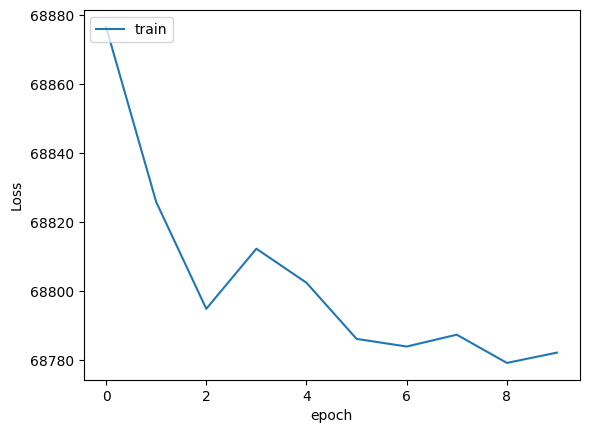

In [ ]:
# Plot loss function
plt.plot(history.history['loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

Molecules generation

32/32 [==============================] - 5s 154ms/step


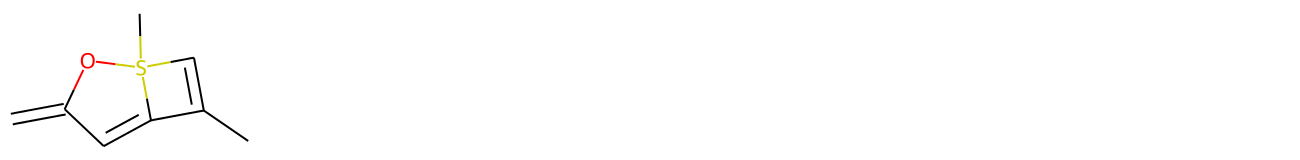

In [ ]:
mol_gen = model.inference(1000)

MolsToGridImage(
    [m for m in mol_gen if m is not None][:1000], molsPerRow=5, subImgSize=(260, 160)
)

In [ ]:
from rdkit import Chem
for m in mol_gen:
  if m is not None:
    smile=Chem.MolToSmiles(m)
    print(smile)

C=C1C=C2C(C)=CS2(C)O1


Check the chemical rules

Null molecules

In [ ]:
# Eliminate null molecules
new_mol_gen2 = []
for m in mol_gen:
  if m is not None:
    new_mol_gen2.append(m)
mol_gen = new_mol_gen2

for m in mol_gen:
  if m is not None:
    smile=Chem.MolToSmiles(m)
    print(smile)

C#C.CC.CCC.CN.CO
Oc1cccnc1
O.c1c2c3cc-3c1-2
CC.CC.CCC


In [ ]:
# Check if there are null molecules
for m in mol_gen:
  if m is None:
      # Molecule is invalid
      print("There is an invalid molecule")

Bonds and atoms

In [ ]:
from rdkit import Chem
new_mol_gen4 = []
for m in mol_gen:
  # Check the number of atoms and bonds
  num_atoms = m.GetNumAtoms()
  num_bonds = m.GetNumBonds()

  if num_atoms > 2 and num_bonds > 1:
      # The molecule has enough atoms and bonds to be valid
      new_mol_gen4.append(m)
mol_gen = new_mol_gen4

Byte rules

In [ ]:
from rdkit import Chem
new_mol_gen5 = []
for m in mol_gen:
  # Check the octet rule for each atom
  for atom in m.GetAtoms():
      valence = atom.GetExplicitValence()
      num_hydrogens = atom.GetTotalNumHs()
      num_lone_pairs = atom.GetNumRadicalElectrons()

      if valence + num_hydrogens + num_lone_pairs == atom.GetTotalValence():
          # The atom respects the octet rule
          new_mol_gen5.append(m)
mol_gen = new_mol_gen5

Valence rule

In [ ]:
new_mol_gen6 = []
for m in mol_gen:
  # Checking the byte rule
  for atom in m.GetAtoms():
    if atom.GetTotalValence() <8:
      new_mol_gen6.append(m)
mol_gen = new_mol_gen6

Formal charges

In [ ]:
from rdkit import Chem
new_mol_gen7 = []
test=0
for m in mol_gen:

  # Check the formal charges for each atom
  for atom in m.GetAtoms():
      formal_charge = atom.GetFormalCharge()
      if formal_charge != 0:
        # atom has a non-zero formal charge
        test=1
  if test==0:
    new_mol_gen7.append(m)
mol_gen = new_mol_gen7

Molecular geometry

In [ ]:
!pip install rdkit --upgrade

In [ ]:
for m in mol_gen:
  # Check molecular geometry
  num_conformers = m.GetNumConformers()
  if num_conformers > 0:
    for conf_id in range(num_conformers):
      conformer = m.GetConformer(conf_id)
      for bond in m.GetBonds():
        bond_length = conformer.GetDistance(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
        print(f"Bond {bond.GetIdx()}: {bond_length:.2f} Angstroms")
  else:
    print("Molecule has no conformers")

Stereochemistry

In [ ]:

new_mol_gen = []
for m in mol_gen:
    # Check stereochemistry
    m = Chem.Mol(m)
    Chem.AssignStereochemistry(m, force=True, cleanIt=True, flagPossibleStereoCenters=True)
    Chem.AssignAtomChiralTagsFromStructure(m, replaceExistingTags=True)
    Chem.AssignStereochemistryFrom3D(m)
    if Chem.FindMolChiralCenters(m, includeUnassigned=True):
        new_mol_gen.append(m)

mol_gen = new_mol_gen

Oxidation number

In [ ]:
new_mol_gen9 = []
test=0
for m in mol_gen:
  # Check oxidation number
  Chem.AssignStereochemistryFrom3D(m)
  for atom in m.GetAtoms():
    if atom.GetFormalCharge() != atom.GetExplicitValence() - atom.GetNumExplicitHs() - atom.GetNumRadicalElectrons():
      test=1
  if test==0:
    new_mol_gen9.append(m)
mol_gen = new_mol_gen9

Atoms connectivity

In [ ]:
new_mol_gen10 = []
test=0
for m in mol_gen:
  # Check atoms connectivity
  for atom in m.GetAtoms():
    if len(atom.GetNeighbors()) != atom.GetExplicitValence():
      test=1
  if test==0:
    new_mol_gen10.append(m)
mol_gen = new_mol_gen10

Bonds

In [ ]:
new_mol_gen11 = []
test=0
for m in mol_gen:
  # Check Bonds
  for bond in m.GetBonds():
    if bond.GetBondType() not in [Chem.BondType.SINGLE, Chem.BondType.DOUBLE, Chem.BondType.TRIPLE]:
      test=1
    if bond.GetStereo() not in [Chem.BondStereo.STEREOE, Chem.BondStereo.STEREOZ, Chem.BondStereo.STEREOCIS, Chem.BondStereo.STEREOTRANS, Chem.BondStereo.STEREOANY]:
      test=1
    if bond.GetBeginAtom().GetDegree() == 1 or bond.GetEndAtom().GetDegree() == 1:
      test=1
  if test==0:
    new_mol_gen11.append(m)
mol_gen = new_mol_gen11

Molar mass

In [ ]:
new_mol_gen12 = []
for m in mol_gen:
  # Check molar mass
  molar_mass = Descriptors.MolWt(m)
  if molar_mass > 0 or molar_mass < 1000:
    new_mol_gen12.append(m)
mol_gen = new_mol_gen12

Isotopes

In [ ]:
new_mol_gen13 = []
test=0
for m in mol_gen:
  # Checking for the presence of isotopes
  isotopes = [i for a in m.GetAtoms() for i in a.GetIsotopes() if i > 0]
  if isotopes:
    for isotope in isotopes:
      relative_abundance = m.GetIsotopeFraction(isotope)
      if relative_abundance < 0 or relative_abundance > 1:
        test=1
  if test==0:
    new_mol_gen13.append(m)
mol_gen = new_mol_gen13

Polarity

In [ ]:
new_mol_gen14 = []
test=0
for m in mol_gen:
  # Check polarity
  polar_atoms = [a for a in m.GetAtoms() if a.GetAtomicNum() in [7, 8, 9, 15, 16, 17, 35, 53]]
  if len(polar_atoms) / m.GetNumAtoms() < 0.1:
    test=1
  if test==0:
    new_mol_gen14.append(m)
mol_gen = new_mol_gen14

Solubility

In [ ]:
new_mol_gen15 = []
test=0
for m in mol_gen:
  # Calcul (logP)
  from rdkit.Chem import Crippen
  logP = Crippen.MolLogP(m)
  # Check solubility
  if logP < -2:
    test=1
  if test==0:
    new_mol_gen15.append(m)
mol_gen = new_mol_gen15

Tanimoto comparison

In [ ]:
db=df.sample(100)

,ChEMBL ID,Name,Synonyms,Type,Max Phase,Molecular Weight,Targets,Bioactivities,AlogP,Polar Surface Area,...,Inorganic Flag,Heavy Atoms,HBA (Lipinski),HBD (Lipinski),#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Molecular Species,Molecular Formula,Smiles,Structure
1731049,CHEMBL294097,NaN,NaN,Small molecule,0,546.69,3.0,4.0,5.62,84.94,...,-1,39,7,1,2,546.2188,NEUTRAL,C31H34N2O5S,CC(C)(C)OC(=O)N[C@@H](Cc1ccc(OCc2ccccc2)cc1)C(...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
432483,CHEMBL1593704,NaN,NaN,Small molecule,0,448.43,3.0,3.0,2.81,105.02,...,-1,32,9,1,0,448.1558,NEUTRAL,C21H22F2N4O5,CCN(CC(=O)Nc1c(F)cccc1F)C(=O)c1cc([N+](=O)[O-]...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
1918097,CHEMBL3400208,NaN,NaN,Small molecule,0,438.62,1.0,1.0,6.27,32.34,...,-1,33,3,1,1,438.2671,BASE,C30H34N2O,O=C([C@@H]1C[C@H]1c1ccccc1)N(CCNCC1CCCC1)c1ccc...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
691386,CHEMBL1629978,NaN,NaN,Small molecule,0,411.44,1.0,1.0,3.61,124.56,...,-1,29,8,3,0,411.0889,NEUTRAL,C20H17N3O5S,COc1ccc(C(=O)Nc2sc(Cc3ccccc3)cc2C(N)=O)cc1[N+]...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
442572,CHEMBL2296342,NaN,NaN,Small molecule,0,370.41,8.0,18.0,5.84,78.84,...,-1,28,6,2,1,370.1430,NEUTRAL,C22H18N4O2,COc1ccccc1NC(=O)c1ccc(/N=N\c2c[nH]c3ccccc23)cc1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"

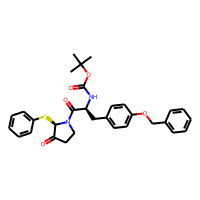
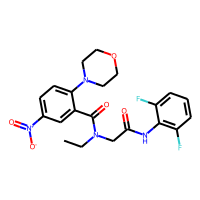
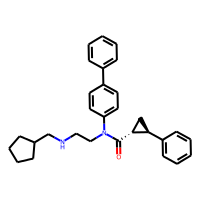
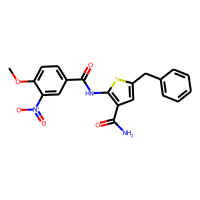
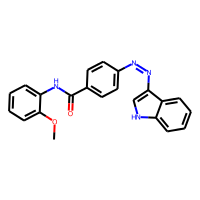

In [ ]:
from rdkit.Chem import PandasTools
PandasTools.AddMoleculeColumnToFrame(db,'Smiles', 'Structure')
db.head(5)

In [ ]:
# Let us find compounds similar to mol_gen[0]
query=mol_gen[2]
query_fps = AllChem.GetMorganFingerprintAsBitVect(query, 2, nBits=4096)
query


In [ ]:
# Calculate the fingerprints of all the compounds
all_Mfpts = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=4096) for mol in db.Structure]


In [ ]:
from rdkit import DataStructs
# Calculate Tanimoto coefficient of the query compound against each of the compounds in the dataset
# Put them in the list
Tanimoto_similarity = [DataStructs.FingerprintSimilarity(query_fps, x, metric=DataStructs.TanimotoSimilarity) for x in all_Mfpts]


In [ ]:
Tanimoto_similarity
# Similar if value >=0,7

[0.029850746268656716,
 0.047619047619047616,
 0.038461538461538464,
 0.05084745762711865,
 0.038461538461538464,
 0.03225806451612903,
 0.05084745762711865,
 0.05660377358490566,
 0.06349206349206349,
 0.04477611940298507,
 0.038461538461538464,
 0.061224489795918366,
 0.019230769230769232,
 0.05,
 0.043478260869565216,
 0.029411764705882353,
 0.075,
 0.018867924528301886,
 0.05194805194805195,
 0.0967741935483871,
 0.05172413793103448,
 0.06557377049180328,
 0.04,
 0.06818181818181818,
 0.0625,
 0.030303030303030304,
 0.056338028169014086,
 0.04,
 0.046153846153846156,
 0.04918032786885246,
 0.043478260869565216,
 0.02564102564102564,
 0.02197802197802198,
 0.0,
 0.03278688524590164,
 0.1111111111111111,
 0.06557377049180328,
 0.05714285714285714,
 0.06557377049180328,
 0.04,
 0.05714285714285714,
 0.045454545454545456,
 0.03389830508474576,
 0.05454545454545454,
 0.046511627906976744,
 0.05263157894736842,
 0.05357142857142857,
 0.04285714285714286,
 0.07692307692307693,
 0.03333333

In [ ]:
# Put the Tanimoto coefficient values into data frame.
db["tanimoto_values"] = Tanimoto_similarity


In [ ]:

# Sort Tanimoto coefficient values in decreasing order
dataset_sorted = db.sort_values(['tanimoto_values'],ascending=False)


In [ ]:
# Show the dataframe
dataset_sorted.drop('Structure', axis=1, inplace=True)
dataset_sorted

,ChEMBL ID,Name,Synonyms,Type,Max Phase,Molecular Weight,Targets,Bioactivities,AlogP,Polar Surface Area,...,Inorganic Flag,Heavy Atoms,HBA (Lipinski),HBD (Lipinski),#RO5 Violations (Lipinski),Molecular Weight (Monoisotopic),Molecular Species,Molecular Formula,Smiles,tanimoto_values
863654,CHEMBL4281929,NaN,NaN,Small molecule,0,384.34,7.0,7.0,2.50,74.76,...,-1,28,6,0,0,384.0922,NEUTRAL,C20H14F2N2O4,O=C1C(=O)N(CCCCN2C(=O)C(=O)c3cc(F)ccc32)c2ccc(...,0.125000
289034,CHEMBL98256,NaN,NaN,Small molecule,0,271.10,6.0,6.0,3.91,48.07,...,-1,17,4,0,0,269.9963,None,C11H8Cl2N2O2,Cn1cc(-c2ccc(Cl)cc2Cl)c([N+](=O)[O-])c1,0.111111
517765,CHEMBL1884707,NaN,NaN,Small molecule,0,181.24,2.0,3.0,1.26,63.81,...,-1,13,4,3,0,181.1215,NEUTRAL,C9H15N3O,Nc1cc(=O)[nH]n1C1CCCCC1,0.096774
1176332,CHEMBL1569383,NaN,NaN,Small molecule,0,226.71,13.0,15.0,3.11,24.39,...,-1,13,2,1,0,172.1000,BASE,C11H15ClN2O,CC1=CC(C)=Nc2ccccc2N1.Cl.O,0.096774
1305326,CHEMBL3687967,NaN,NaN,Small molecule,0,297.27,1.0,1.0,3.32,91.29,...,-1,22,7,0,0,297.0750,NEUTRAL,C15H11N3O4,COc1ccccc1-c1nc(-c2cccc([N+](=O)[O-])c2)no1,0.085106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1126723,CHEMBL1459906,NaN,NaN,Small molecule,0,299.40,3.0,4.0,1.64,99.77,...,-1,20,7,3,0,299.1416,NEUTRAL,C12H21N5O2S,CC(C)c1n[nH]c(SCC(=O)NC(=O)NC(C)(C)C)n1,0.021739
915657,CHEMBL1396745,NaN,NaN,Small molecule,0,347.50,7.0,8.0,4.79,58.89,...,-1,25,4,1,0,347.2460,NEUTRAL,C21H33NO3,COC(=O)[C@]1(C)CCC[C@@]2(C)C3CC[C@@]4(C)C[C@]3...,0.019231
1092265,CHEMBL3274609,NaN,NaN,Small molecule,0,359.53,2.0,5.0,3.64,77.84,...,-1,24,5,2,0,359.2130,ACID,C18H33NO4S,CCCCCC(O)CCC1SCC(=O)N1CCCCCCC(=O)O,0.018868
1214354,CHEMBL3503839,NaN,NaN,Small molecule,0,518.41,10.0,18.0,0.62,50.60,...,-1,21,6,0,0,290.1743,NEUTRAL,C19H24F6N4O6,Cn1nc(C(=O)N2CCOCC2)c2c1CN(CC1CC1)C2.O=C(O)C(F...,0.017857
